In [1]:
# Data handling
import pandas as pd
import numpy as np
import data_prep  #! make sure that the files are in the same folder

# check computation time
import time

# Modelling
from sklearn.ensemble import RandomForestClassifier

# Feature importance
from sklearn.inspection import permutation_importance

# Hyper parameter tuning
from sklearn.model_selection import RandomizedSearchCV

# Performance measures
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, explained_variance_score,max_error


# Tree Visualisation
import os
from sklearn.tree import export_graphviz

from subprocess import call
from IPython.display import Image

# Prediction visualisation
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import matplotlib.cm as cm # Has to be last due to overlapping functions from other packages

In [2]:
start_time_total = time.time()
start_time = time.time()
# Run the model
import fire

elapsed_time = time.time() - start_time

print(f"\n Elapsed time to run simulation model: {elapsed_time:.3f} seconds")

....................................................................................................
 Elapsed time to run simulation model: 8.194 seconds


In [3]:
# Assign static features ---- array has length of 1x( all pixels ) x (all simulated versions)
dem = fire.dem_array

# Assign dynamic features ---- array has length of (timesteps) x ( all pixels ) x (all simulated versions)
firedata = fire.fire_array
areafire = fire.Area_fire_array

#Retrieve size of frame and timesteps
horizontal_pixels  = fire.horizontal_pixels
vertical_pixels = fire.vertical_pixels
timesteps = fire.timesteps

In [4]:
np.unique(areafire).max()

412.0

In [5]:
# Assign feature of interest to 'data'
data = firedata
# Repeat Static drivers for each timestep
dem = np.repeat(dem, timesteps)

In [6]:
list_drivers = [dem]
list_driver_names = ['dem']

In [13]:
neighbour = False
if neighbour:
    df = data_prep.neighbour_as_feature(data, horizontal_pixels, vertical_pixels, multiplesteps =False)

if not neighbour:
    df = data_prep.only_y_label(data, horizontal_pixels, vertical_pixels, multiplesteps = False)

Total number of data points :  8910000
Length of one row of pixels, horizontal side of the grid:  300


In [8]:
# Add drivers at each timestep and each pixel to the dataframe
for _ in range(len(list_drivers)):
    driver = list_drivers[_]
    name = list_driver_names[_]

    # Add driver at each timestep and each pixel to the dataframe
    df = data_prep.driver_as_feature(df=df,
                                     driver=driver, driver_name=name,
                                     horizontal_pixels=horizontal_pixels,
                                     vertical_pixels=vertical_pixels,
                                     multiplesteps=False)


In [9]:
# Name features and labels
features = df.iloc[:, :-1]
labels = df.iloc[:, -1]

# Extract feature names for later processing
colnames = list(df.columns.values.tolist())
feature_names = colnames[:-1]
label_name = colnames[-1]
print(feature_names)
print(features.shape)
print(label_name)
print(labels.shape)

['x_input', 'dem']
(8910000, 2)
y_label
(8910000,)


In [ ]:
# df.head()

In [10]:
# Split train/test

length_one_simulation = timesteps*vertical_pixels*horizontal_pixels
one_time_step = horizontal_pixels*vertical_pixels

# Split at last timestep to predict last timestep
X_train = features.iloc[:, :]
y_train = labels.iloc[:]

# The test set only contains the first initialised values for the simulation. The rest is predicted
X_test = features.iloc[:(one_time_step), :]

# Since we want to predict the entire simulation we do not have a set ylabel. Perhaps later construct y_label from all following simulated steps. But time series of important points generates a better view of the performance
y_test =  labels.iloc[:]

# Check train/test
print('X_train ', X_train.shape) #training features
print('Y_train ', y_train.shape) #training labels

print('X_test (only 1st step of last simulation)', X_test.shape) #testing features
print('Y_test (multiplestep Y>>X, complete simulation)', y_test.shape) #testing labels

print('Features ', features.shape) #total just to check if testing is really not inside training. shapes add up
print('Labels ', labels.shape)

optimise_model_true = False

if optimise_model_true:
    # Altogether, there are many possible settings.
    # However, the benefit of a random search is that we are not trying every combination, but selecting at random to sample a wide range of values.

    from sklearn.model_selection import RandomizedSearchCV

    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start=10, stop=500, num=8)]
    # Number of features to consider at every split
    max_features = [1.0, 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(1, 200, num=10)]

    # Minimum number of samples required to split a node
    min_samples_split = [2, 4, 6]

    # Minimum number of samples required at each leaf node
    min_samples_leaf = [4, 8, 16]

    # Method of selecting samples for training each tree
    bootstrap = [True, False]

    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

    # Use the random grid to search for best hyperparameters
    # First create the base model to tune
    rf = RandomForestClassifier()

    # Random search of parameters, using 3 fold cross validation,
    # search across 400 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator=rf,
                                   param_distributions=random_grid,
                                   n_iter=100,
                                   cv=3,
                                   verbose=4,
                                   random_state=42,
                                   n_jobs=-1)

    # Fit the random search model
    rf_random.fit(X_train, y_train)
    print(rf_random.best_params_)

else:
    # fit the model
    rf = RandomForestClassifier(n_estimators=30,
                               min_samples_split=2,
                               min_samples_leaf=4,
                               max_features=1.0,
                               max_depth=67,
                               bootstrap=True)
    rf.fit(X_train, y_train)

X_train  (8910000, 2)
Y_train  (8910000,)
X_test (only 1st step of last simulation) (90000, 2)
Y_test (multiplestep Y>>X, complete simulation) (8910000,)
Features  (8910000, 2)
Labels  (8910000,)


In [11]:
y_test =  labels.iloc[:]

In [12]:

# Predict one complete simulation on unseen variable
# list_drivers_once = [list_precipitation[0],list_temp[0], list_dem[0]]
list_drivers_once = list_drivers
# -1 timestep due to removed last timesteps to avoid NaN's in Labels
steps = timesteps-1

# Initialise for saving predictions for animation and performance measures, respectively.
framed_predictions = pd.DataFrame()
array_predictions = np.empty(0)
list_each_prediction = [None] *steps

#Choose the initial starting state of the model as the Test set
X_test_multiple = X_train.iloc[:(horizontal_pixels*vertical_pixels),:]

In [ ]:
start_time = time.time()
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to run whole script: {elapsed_time:.3f} seconds")



forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Fire - Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.plot()
plt.savefig('Results/Fire_feature_MDI.png')
plt.show()
plt.close()

In [ ]:

start_time = time.time()
result = permutation_importance(
    rf, X_test, y_test[:one_time_step], n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Snowmelt - Feature importance using permutation")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.plot()
plt.savefig('Snowmelt_feature_permutations.png')
plt.show()
plt.close()

In [15]:
# - Make predictions
# - Save prediction
# - Set prediction as new input
#
# - Add static and dynamic drivers to new input

last_pixel_driver = 0
array_area_pred = np.empty(0)
for _ in range(steps):
    print(_)
    # Prediction step
    y_pred_rf = rf.predict(X_test_multiple)

    # Save the solution as a dataframe of pixels
    # For animation
    projected_prediction = pd.DataFrame(np.reshape(y_pred_rf,(int(vertical_pixels),int(horizontal_pixels))))
    framed_predictions = pd.concat([framed_predictions, projected_prediction], axis=0)

    Area_of_fire_predicted = len(y_pred_rf[y_pred_rf == 1])
    array_area_pred = np.append(array_area_pred, Area_of_fire_predicted)

    # For MSE map
    list_each_prediction[_] = projected_prediction

    # For performance measures
    array_predictions = np.append(array_predictions, y_pred_rf)

    if not neighbour:
        # Create the new test set for next prediction
        new_state = data_prep. only_y_label(y_pred_rf.reshape(-1,1),
                                               horizontal_pixels,
                                               vertical_pixels,
                                               multiplesteps=True,
                                               print_true= False)
    if neighbour:
        # Create the new test set for next prediction
        new_state = data_prep. only_y_label(y_pred_rf.reshape(-1,1),
                                               horizontal_pixels,
                                               vertical_pixels,
                                               multiplesteps=True,
                                               print_true= False)

    # Add the drivers at that timestep
    first_pixel_driver = last_pixel_driver
    last_pixel_driver = first_pixel_driver + (vertical_pixels*horizontal_pixels)
    for __ in range(len(list_drivers_once)):
        driver = list_drivers_once[__]
        name = list_driver_names[__]
        new_state = data_prep.driver_as_feature(df = new_state,
                                                driver=driver[first_pixel_driver:(last_pixel_driver)],
                                                driver_name= name,
                                                horizontal_pixels=horizontal_pixels,
                                                vertical_pixels=vertical_pixels,
                                                multiplesteps=True)



    # remove the Y_label-- y_label only used for training
    X_test_multiple = new_state.iloc[:, :-1]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98


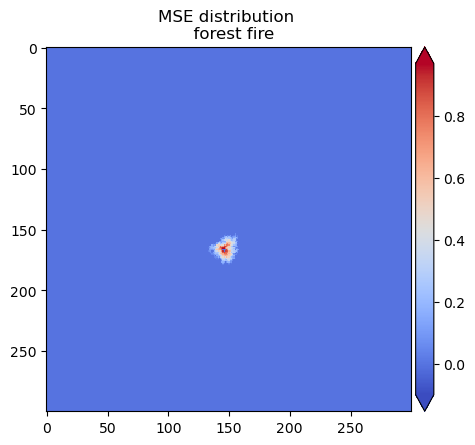

In [16]:

# Generate results:
# MSE_map: Mean of each pixel averaged over all timesteps

# Reshape y_test for MSE. Same shape as framed predictions. vertical x horziontal with next timestep below.
framed_y_test = pd.DataFrame()
first_pixel_y_test = 0
y_test = pd.Series(y_test)
list_y_test_ = [None] * steps

for _ in range(steps):

    last_pixel_y_test = one_time_step*(_+1)
    # print("last pixel = ",last_pixel_y_test)
    # print("first pixel = ", first_pixel_y_test)
    # print('length y_test = ', len(y_test))
    # print('length y_test[i:j] = ', len(y_test[first_pixel_y_test:last_pixel_y_test]))
    projected_y_test = pd.DataFrame(y_test[first_pixel_y_test:last_pixel_y_test].values.reshape((int(vertical_pixels),int(horizontal_pixels))))
    list_y_test_[_] = projected_y_test
    framed_y_test = pd.concat([framed_y_test, projected_y_test], axis=0)

    first_pixel_y_test = last_pixel_y_test

squared_difference = [None] * steps
test_concat = pd.DataFrame()
for __ in range(steps):
    # print(__)
    squared_difference[__] = (list_each_prediction[__] - list_y_test_[__])**2

dfs = squared_difference
MSE_map = pd.concat([each.stack() for each in dfs],axis=1)\
             .apply(lambda x:x.mean(),axis=1)\
             .unstack()


fig, ax = plt.subplots(figsize=(5,5))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cmap = cm.coolwarm
im = ax.imshow(MSE_map, interpolation='nearest', cmap=cmap, vmin=MSE_map.to_numpy().max(), vmax=MSE_map.to_numpy().min())
ax.set_title('MSE distribution \n  forest fire')
fig.colorbar(im,cax=cax, orientation='vertical', extend = 'both')#, ticks= [0.05,0.1,0.15,0.2,0.25])

plt.plot()
plt.savefig('Results/no_neighbours_fire_MSE_map.png')
plt.show()
plt.close()

In [17]:

# overall MSE/MAPE/MAE/Explained variance
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, explained_variance_score,max_error

# Mean absolute percentage error (MAPE) regression loss.
#
# Note here that the output is not a percentage in the range [0, 100] and a value of 100 does not mean 100% but 1e2. Furthermore, the output can be arbitrarily high when y_true is small (which is specific to the metric) or when abs(y_true - y_pred) is large (which is common for most regression metrics).


MAPE = mean_absolute_percentage_error(y_true=y_test, y_pred = array_predictions)
MAE = mean_absolute_error(y_true=y_test, y_pred = array_predictions)
MSE = mean_squared_error(y_true=y_test, y_pred = array_predictions)
MAX = max_error(y_true=y_test, y_pred = array_predictions)
EXPL_VAR = explained_variance_score(y_true=y_test, y_pred = array_predictions)

# print('mean absolute percentage: ', MAPE) Too small y_true values for this measure??
print('mean absolute error: ',MAE)
print('mean squared error: ',MSE)
print('MAX ERROR: ',MAX)
print('Explained variance score: ',EXPL_VAR)

mean absolute error:  0.0014585858585858585
mean squared error:  0.0014585858585858585
MAX ERROR:  1.0
Explained variance score:  0.9933060893117671


In [26]:
len(areafire[:plot_xvalues])

98

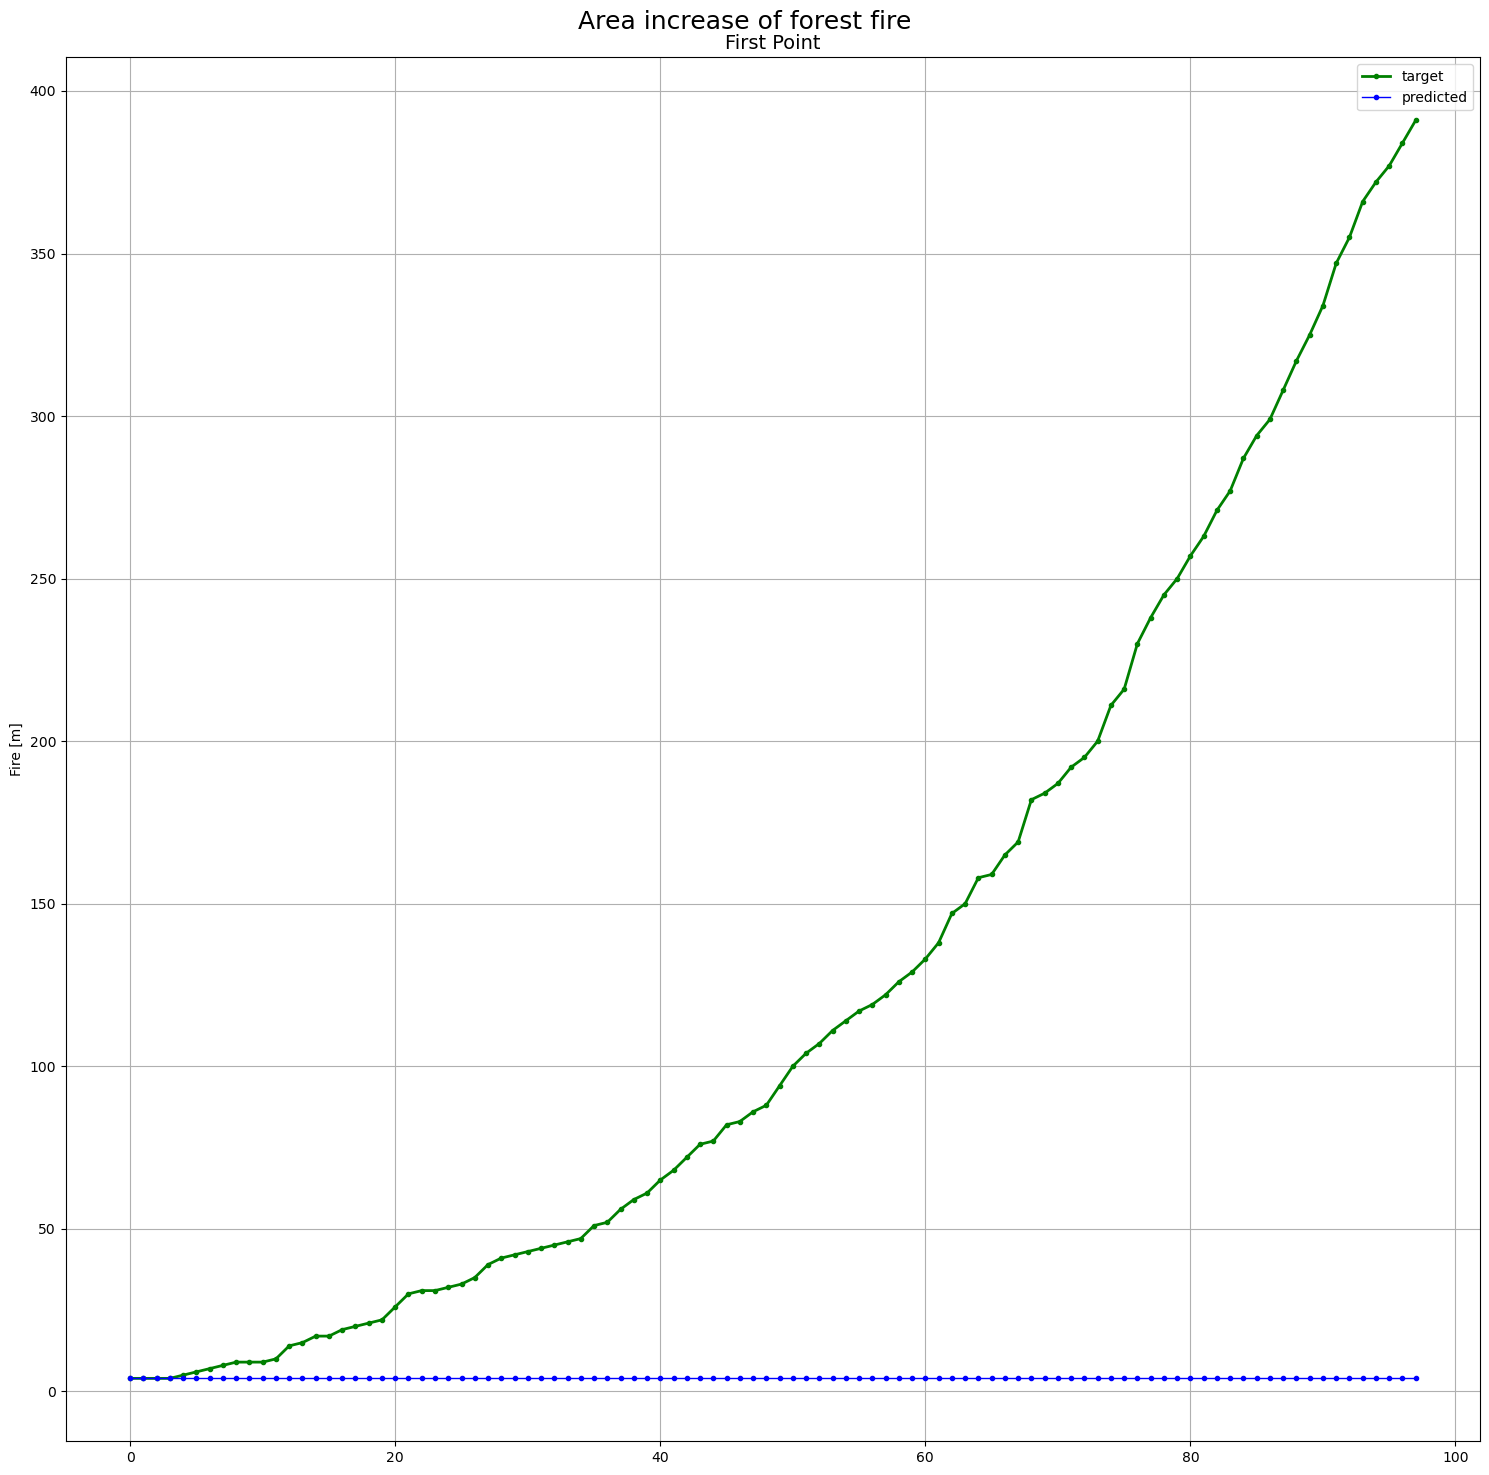

Elapsed time to run whole script: 459.517 seconds


In [27]:
# Visualise predictions

# Initialise the points
areafire
array_area_pred

# Extract the timeseries data of these points from the simulated and emulated data
plot_xvalues = timesteps-2

fig, ax = plt.subplots(1, 1, figsize=(15,15))
fig.suptitle('Area increase of forest fire', fontsize=18)

#---- point 1
ax.plot(range(plot_xvalues), areafire[:plot_xvalues], '.-', color = 'green', linewidth= 2)
ax.plot(range(plot_xvalues), array_area_pred[:plot_xvalues], '.-', color = 'blue', linewidth= 1.0)

ax.set_title('First Point', fontsize = 14)
ax.set_ylabel('Fire [m]')
ax.legend(['target', 'predicted'])
ax.grid()


fig.tight_layout()
# plt.subplot_tool()
plt.plot()
plt.savefig('Results/no_neighbours_fire_timeseries.png')
plt.show()
plt.close()


elapsed_time = time.time() - start_time_total

print(f"Elapsed time to run whole script: {elapsed_time:.3f} seconds")


In [31]:
print(len(firedata))
print(one_time_step)

9000000
90000
